In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pickle
import os
from ANEMO import read_edf
from ANEMO import ANEMO

from scipy import stats

%matplotlib inline

In [2]:
sujet = ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']
time = ['2017-10-23_100057','2017-09-26_095637', '2017-10-03_134421','2017-09-27_161040',
        '2017-10-03_143803','2017-09-28_115250', '2017-09-20_151043','2017-10-26_121823',
        '2017-11-08_094717','2017-11-16_153313', '2017-11-08_150410','2017-11-17_172706']

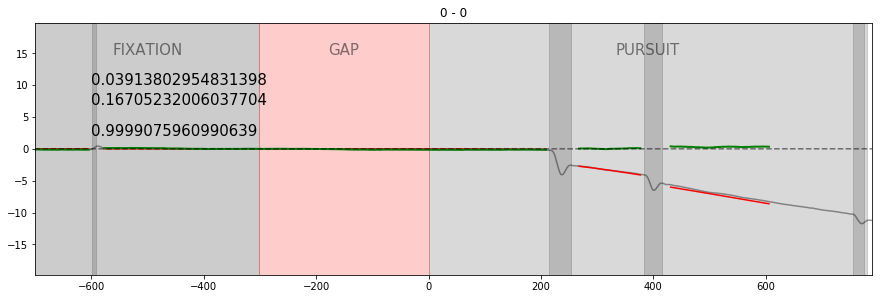

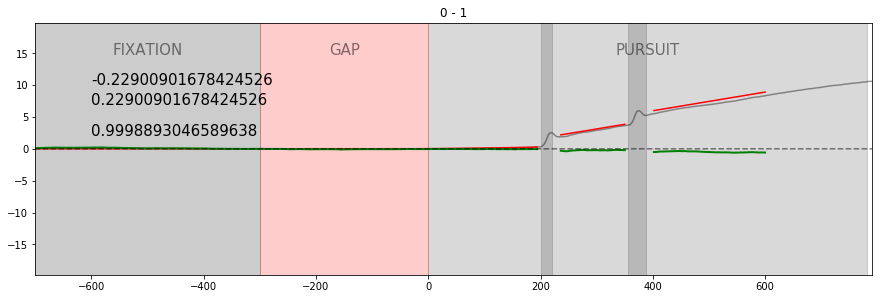

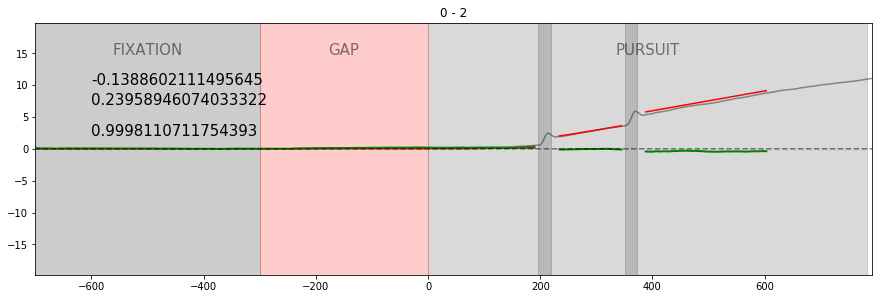

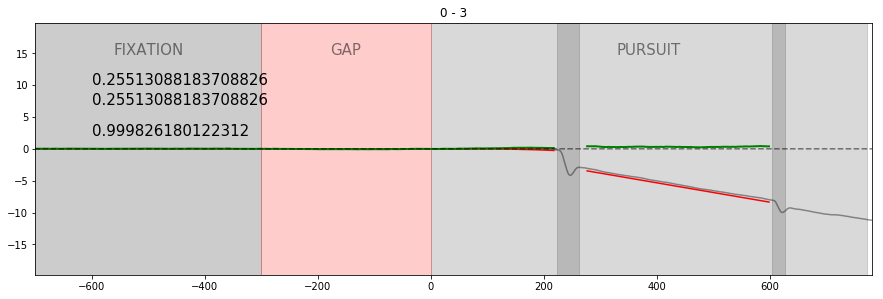

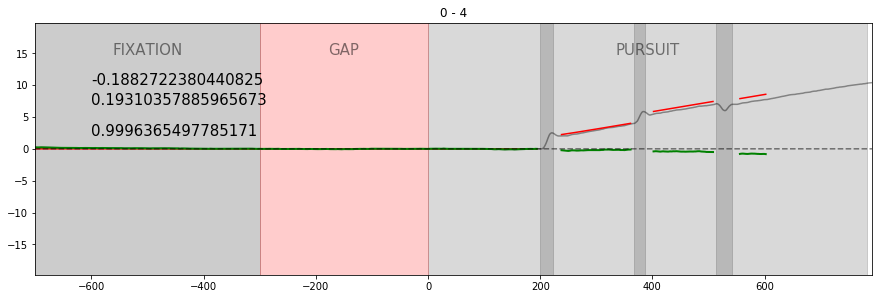

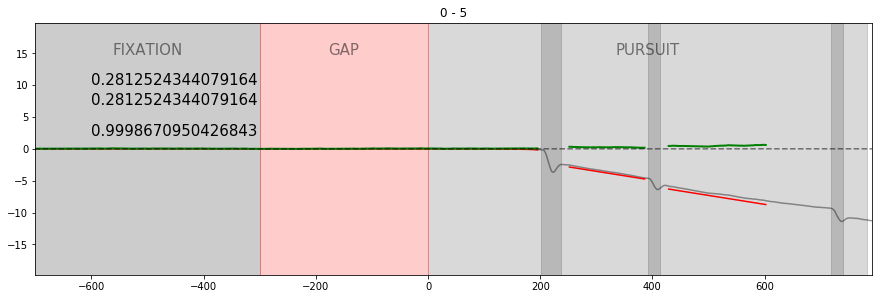

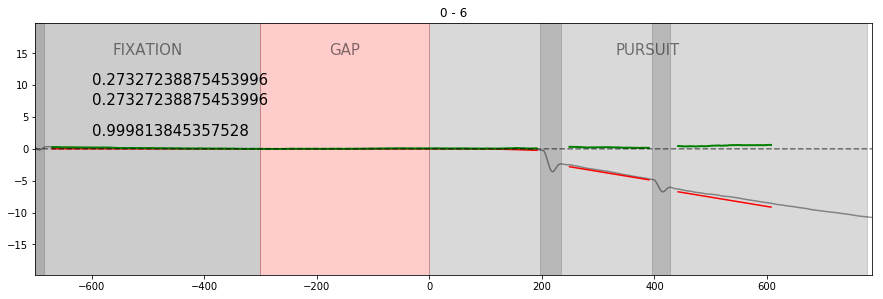

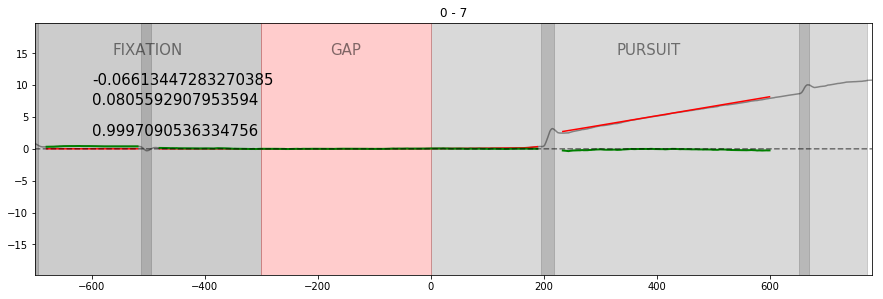

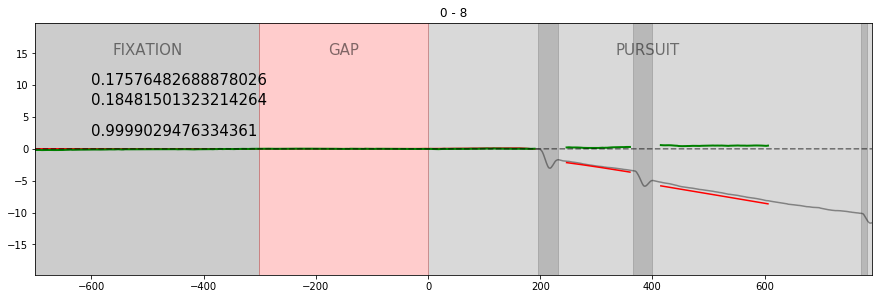

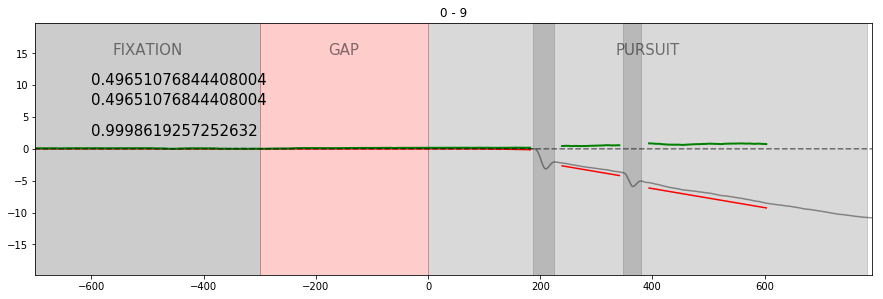

In [3]:
for x in [0] : #range(len(sujet)) :
    
    
    file = os.path.join('data', 'enregistrement_' + sujet[x] + '_' + time[x] + '.pkl')
    with open(file, 'rb') as fichier : param_exp = pickle.load(fichier, encoding='latin1')
    
    resultats = os.path.join('data', 'enregistrement_' + sujet[x] + '_' + time[x] + '.asc')
    data = read_edf(resultats, 'TRIALID')

    file = os.path.join('parametre/param_Fit_'+ sujet[x] +'_fct_velocity_2_step_False_whitening.pkl')
    with open(file, 'rb') as fichier : param_fit = pickle.load(fichier, encoding='latin1')

    
    A = ANEMO(param_exp)
    Plot = A.Plot(param_exp)
    
    N_trials, N_blocks = param_exp['N_trials'], param_exp['N_blocks']

    for block in range(1) :
        for trial in range(10) :

            trial_data = trial + N_trials*block
            arg = A.arg(data[trial_data], trial=trial, block=block)

            fig, ax = Plot.plot_data(data, show='positon', trials=trial, block=block)

            onset = arg.TargetOn-arg.t_0
            x = np.arange(len(arg.trackertime))

            start_anti = int(param_fit['start_anti'][block][trial] + onset)
            v_anti = param_fit['v_anti'][block][trial]

            latence = int(param_fit['latence'][block][trial] + onset)
            tau = param_fit['tau'][block][trial]
            maxi = param_fit['maxi'][block][trial]

            sacc = np.zeros(len(arg.trackertime))
            i=0
            for s in range(len(arg.saccades)):
                sacc[i]   = arg.saccades[s][0] # onset sacc
                sacc[i+1] = arg.saccades[s][1] # end sacc
                sacc[i+2] = arg.saccades[s][2] # time sacc
                i = i+3


            fit = A.Equation.fct_position(x, arg.data_x, sacc, len(arg.saccades),
                                          arg.dir_target, start_anti , v_anti,
                                          latence, tau, maxi, arg.t_0,
                                          arg.px_per_deg, before_sacc=5.,
                                          after_sacc=15., do_whitening=False)
            
            ax.plot(arg.trackertime[:-280]-arg.TargetOn, fit[:-280], 'r')
            
            d_x = A.data_deg(arg.data_x, arg.StimulusOf,arg.t_0, arg.saccades, before_sacc=5, after_sacc=15)
            
            ax.plot(arg.trackertime[:-280]-arg.TargetOn, d_x[:-280]-fit[:-280], 'green', lw=2)
            
            ax.plot(arg.trackertime-arg.TargetOn, np.zeros(len(arg.trackertime)), '--k', alpha=.5)
            
            d_x_ss_nan = np.ma.masked_array(d_x[start_anti:-280], mask=np.isnan(fit[start_anti:-280])).compressed()
            fit_ss_nan = np.ma.masked_array(fit[start_anti:-280], mask=np.isnan(fit[start_anti:-280])).compressed()
            
            
            #ax.plot(arg.trackertime[start_anti:start_anti+len(d_x_ss_nan)]-arg.TargetOn, d_x_ss_nan, 'c')
            #ax.plot(arg.trackertime[start_anti:start_anti+len(fit_ss_nan)]-arg.TargetOn, fit_ss_nan, 'c')
            #ax.plot(arg.trackertime[start_anti:start_anti+len(fit_ss_nan)]-arg.TargetOn, d_x_ss_nan-fit_ss_nan, 'c')
            
            #ax.text(-600, 10, np.nanmean(d_x[start_anti:-280]-fit[start_anti:-280]), fontsize=15)
            #ax.text(-600, 7, np.nanmean(abs(d_x[start_anti:-280]-fit[start_anti:-280])), fontsize=15)
            
            ax.text(-600, 10, np.nanmean(d_x_ss_nan-fit_ss_nan), fontsize=15)
            ax.text(-600, 7, np.nanmean(abs(d_x_ss_nan-fit_ss_nan)), fontsize=15)
            
            ax.text(-600, 2, np.corrcoef(d_x_ss_nan, fit_ss_nan)[0][1] , fontsize=15)
            
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_title('%s - %s'%(block,trial))
            